# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

64672


# 1. Pre-processing info

In [9]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 800,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [10]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


25 fovs detected
Creating segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation
Creating cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\CandSpots
Creating decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder


In [11]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [12]:
save_fov_ids = save_fov_ids[:20]
save_filenames = save_filenames[:20]

# 2. Translate segmentation

## 2.1 load rotation matrix

'\\\\10.245.74.158\\Chromatin_NAS_4\\20220316-P_brain_CTP11-12-13_from_0304'

In [16]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220329-M1_renamed\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(save_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    os.makedirs(merfish_dapi_folder)
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99998841 -0.00481543]
 [ 0.00481543  0.99998841]],
 translation:[ 412.64412197 -655.60133037]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\translation


## 2.2 save DAPI image for RNA

In [17]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 161


In [18]:
overwrite_dapi = False
for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _im = ia.visual_tools.DaxReader(os.path.join(ref_fd, rna_fovs[_fov_id])).loadAll()
        _dapi_im = _im[3::4]
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [13:49<00:00, 41.46s/it]


## 2.3 Prepare args

In [ ]:
segmentation_savefiles = []

In [22]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [23]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

20
Wall time: 737 ms


## 2.4 test run and plot

In [31]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 1
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    microscope_file, R, debug=True, 
)

_dna_mask, _full_rna_mask, _rna_dapi, _rot_rna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -0.5 -83.1] in 1.487s.
-- drift 1: [ -0.1  -5.1 -81.1] in 1.496s.
-- drift 2: [ -0.2  -0.5 -80.9] in 1.456s.
-- drift 3: [  0.   -0.2 -78.2] in 1.507s.
-- drift 4: [ -0.1  -0.5 -78. ] in 1.483s.
-- drift 5: [  0.   -4.2 -79.8] in 1.486s.
-- drift 6: [ -0.2  -2.8 -83.8] in 1.452s.
-- drift 7: [ -0.1  -0.6 -83.5] in 1.539s.
-- return a sub-optimal drift
--- drift: [ -0.1   -0.4  -79.03] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


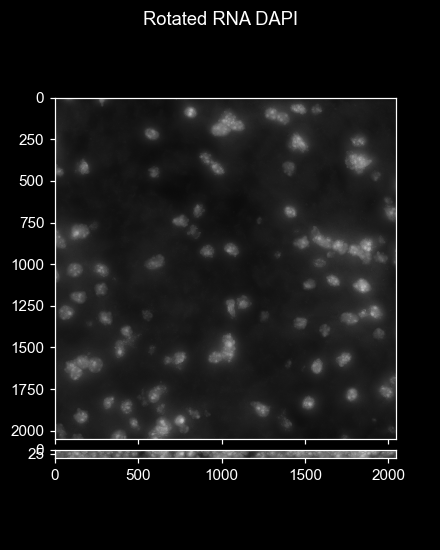

In [32]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_rna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated RNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

<IPython.core.display.Javascript object>


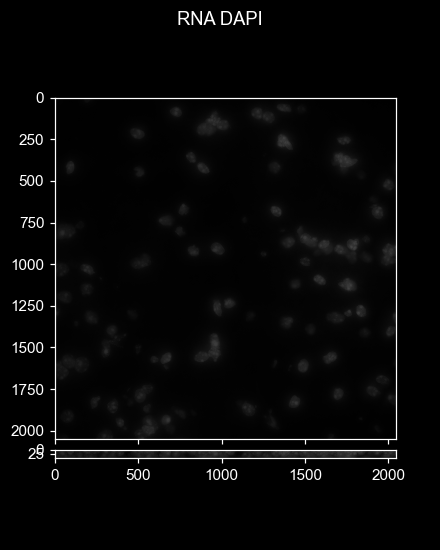

In [33]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_rna_dapi], 
                                         #min_max_default=[500,8000], 
                                         image_names=['RNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_rna_dapi.png'), transparent=True)

## 2.5 batch run translation

In [36]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(8) as _seg_pool:
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 109.587s. 
Wall time: 1min 49s


# 3 Partition DNA-MERFISH spots

In [11]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [12]:
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
import ImageAnalysis3.io_tools.spots 
reload(segmentation_tools.cell)
reload(io_tools.spots)
reload(ia.classes.preprocess)
reload(ia.classes.partition_spots)

<module 'ImageAnalysis3.classes.partition_spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\partition_spots.py'>

## 3.1 prepare spots for partition


In [13]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = True

#_total_seg_save_file defined in 2.3
_partition_args = []

In [16]:
%%time
for _fov_id, _save_filename in zip(save_fov_ids[-1:], save_filenames[-1:]):
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_total_seg_save_file)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, 'combo', None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, 'relabeled_combo', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, 60, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:114 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
1
Wall time: 15.7 s


In [17]:
%%time
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(16) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 232.900s. 
Wall time: 3min 52s


# 3. Decoding of DNA-MERFISH

In [30]:
# load two codebooks
import pandas as pd
codebook_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
codebook_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
codebook_se['id'] = codebook_se['id'] + np.max(codebook_gn['id'])

### re-sort chr_order

In [31]:
# combine region_ids
merged_codebook = pd.concat([codebook_gn, codebook_se], axis=0, join='outer',ignore_index=True).fillna(0)

merged_codebook['reg_start'] = [int(_name.split(':')[1].split('-')[0]) for _name in merged_codebook['name']]
merged_codebook['reg_end'] = [int(_name.split(':')[1].split('-')[1]) for _name in merged_codebook['name']]
merged_codebook['reg_mid'] = (merged_codebook['reg_start'] + merged_codebook['reg_end'])/2

for _chr in np.unique(merged_codebook['chr']):
    _chr_codebook = merged_codebook[merged_codebook['chr']==_chr]
    _reg_order = np.argsort(merged_codebook.loc[merged_codebook['chr']==_chr, 'reg_mid'])
    merged_codebook.loc[_chr_codebook.index[_reg_order], 'chr_order'] = np.arange(len(_chr_codebook))
    
# cleanup 
codebook_df = merged_codebook[[_c for _c in merged_codebook.columns if 'reg_' not in _c]]

In [32]:
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
codebook_df.to_csv(os.path.join(decoder_folder, 'merged_codebook.csv'), index=False)

## 3.2 load spot files

In [33]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 prepare decoding args

In [48]:
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [87]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
return_decoder = False
skip_exist = True
load_exist = True

pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        if os.path.exists(_decoder_filename) and skip_exist:
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, combo_ids,
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 load_exist, overwrite_decoder, return_decoder, False) 
        # append
        decode_args.append(_args)
    
print(len(decode_args))

- Preparing decoding args for fov: 128
13
Wall time: 4.8 s


## 3.4 test decode one cell

In [70]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 30
test_arg = list(decode_args[_cell_ind])
test_arg[16] = True
test_arg[18] = True
decoder = decode.batch_decode_DNA(*tuple(test_arg))

Not enough cand_spots (960) found, skip.


### 3.4.2 visualize decoded spots

In [58]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder
Use decode_figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Figures


<IPython.core.display.Javascript object>


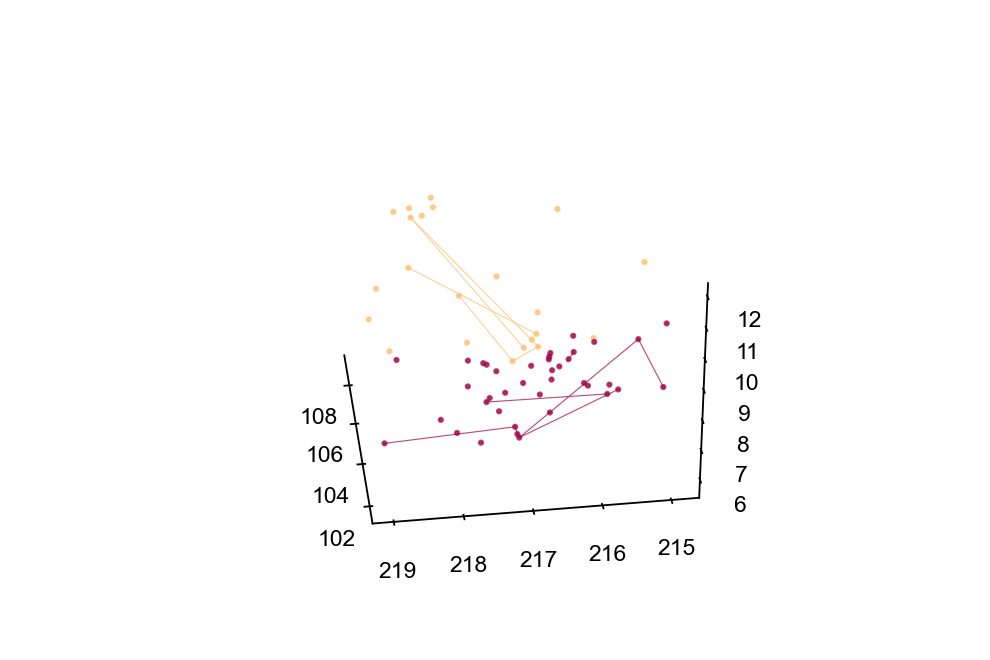

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [59]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_chr_name = '1'
_zxys_list = np.array(decoder.chr_2_zxys_list[_chr_name])/1000

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=30)
ani.save(os.path.join(decode_figure_folder, 
                      os.path.basename(decoder.savefile).replace('.hdf5', f'_Picked_chr-{_chr_name}.gif')), 
         writer=animation.PillowWriter(fps=30))

plt.show()

## 3.5 process all

In [88]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(20) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

13
Wall time: 1min 5s
